In [1]:
%cd ../../

/home/dmoreno/ATAT_ZTF/elasticc_one


In [2]:
import pandas as pd
import numpy as np
import torch
import os

import warnings
warnings.filterwarnings('ignore')

from sklearn.model_selection import train_test_split

/home/dmoreno/miniconda3/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"

In [4]:
path_data = './data/final/ZTF_ff/LC_MD_FEAT_v2_windows'

order_classes = ['SNIa', # yes
                 'SNIbc', # yes
                 'SNIIb', # yes
                 'SNII', # yes
                 'SNIIn', # yes
                 'SLSN', # yes
                 'TDE', # yes
                 'Microlensing', # yes
                 'QSO', 
                 'AGN', # yes
                 'Blazar', 
                 'YSO', 
                 'CV/Nova', 
                 'LPV', 
                 'EA', 
                 'EB/EW', # yes
                 'Periodic-Other', 
                 'RSCVn', 
                 'CEP', 
                 'RRLab', 
                 'RRLc', 
                 'DSCT']

In [5]:
import yaml

def load_yaml(path):
    with open(path, 'r') as file:
        args = yaml.load(file, Loader=yaml.FullLoader)
    return args

dict_info = load_yaml('{}/dict_info.yaml'.format(path_data))

mapping_classes = dict_info['mapping_classes']
mapping_classes_inverted = {v: k for k, v in mapping_classes.items()}
print(mapping_classes_inverted)

{5: 'AGN', 15: 'Blazar', 11: 'CEP', 14: 'CV/Nova', 1: 'DSCT', 12: 'EA', 2: 'EB/EW', 7: 'LPV', 21: 'Microlensing', 13: 'Periodic-Other', 3: 'QSO', 10: 'RRLab', 8: 'RRLc', 4: 'RSCVn', 18: 'SLSN', 19: 'SNII', 16: 'SNIIb', 0: 'SNIIn', 6: 'SNIa', 20: 'SNIbc', 17: 'TDE', 9: 'YSO'}


In [6]:
def sort_dict_by_value(d, reverse=False):
    return dict(sorted(d.items(), key=lambda x: x[1], reverse=reverse))

sort_classes = list(sort_dict_by_value(mapping_classes).keys())
print(sort_classes)

['SNIIn', 'DSCT', 'EB/EW', 'QSO', 'RSCVn', 'AGN', 'SNIa', 'LPV', 'RRLc', 'YSO', 'RRLab', 'CEP', 'EA', 'Periodic-Other', 'CV/Nova', 'Blazar', 'SNIIb', 'TDE', 'SLSN', 'SNII', 'SNIbc', 'Microlensing']


In [7]:
objects = pd.read_parquet('./data/partitions/v2/partitions.parquet')
objects['aid'] = objects.oid.apply(lambda x: 'aid_{}'.format(x))
objects

,oid,alerceclass,partition,aid
index,,,,
5039,ZTF19abpidqn,SNIIn,test,aid_ZTF19abpidqn
12508,ZTF18acermlg,DSCT,test,aid_ZTF18acermlg
16747,ZTF18absxqzn,EB/EW,test,aid_ZTF18absxqzn
33294,ZTF19adhgywz,QSO,test,aid_ZTF19adhgywz
20290,ZTF20aalmrrd,RSCVn,test,aid_ZTF20aalmrrd
...,...,...,...,...
41727,ZTF18abxoxih,Blazar,validation_4,aid_ZTF18abxoxih
41728,ZTF18abnclgk,RRLab,validation_4,aid_ZTF18abnclgk
41735,ZTF18adbhpsf,Blazar,validation_4,aid_ZTF18adbhpsf


## ATAT predictions

In [8]:
#atat_predictions = torch.load('results/ZTF/LC_MD_FEAT/tm_1e-4_cosineAnnealing_clip/MTA/atat_all_predictions_times.pt')
atat_predictions = torch.load('results/ZTF/LC_MD_FEAT/prueba_lc_md_feat_mta_v2_windows/MTA/all_predictions_times.pt')
atat_predictions

{'SNID': array([b'ZTF17aaaecgi_0', b'ZTF17aaaecgi_1', b'ZTF17aaaecgi_2', ...,
        b'ZTF23abcvqkd_3', b'ZTF23abcvqkd_4', b'ZTF23abcvqkd_5'],
       dtype=object),
 'y_test': tensor([2, 2, 2,  ..., 6, 6, 6]),
 'list_y_pred': {'test_16': array([12,  2,  2, ..., 19, 19, 19]),
  'test_32': array([ 2,  2,  2, ..., 19, 16,  6]),
  'test_64': array([ 2,  2,  2, ..., 19, 19,  6]),
  'test_128': array([ 2,  2,  2, ..., 19, 19,  6]),
  'test_256': array([ 2,  2,  2, ..., 19, 19,  6]),
  'test_512': array([ 2,  2,  2, ..., 19,  6,  6]),
  'test_1024': array([ 2,  2,  2, ..., 19,  6,  6]),
  'test_2048': array([2, 2, 2, ..., 6, 6, 6])},
 'list_y_pred_prob': {'test_16': array([[6.6730954e-11, 1.0940837e-03, 3.1876701e-01, ..., 4.3237228e-10,
          6.9853623e-10, 1.2553594e-11],
         [1.1172583e-10, 7.6153030e-04, 6.7463577e-01, ..., 9.0121979e-11,
          3.1843755e-10, 5.5606761e-12],
         [3.4219034e-11, 2.4041331e-03, 7.4660689e-01, ..., 4.0153336e-11,
          3.3124371e-11, 4

### ATAT: Calculate the average of the windows generated from each light curve.

In [9]:
# Procesamiento para agregar los índices correspondientes
from itertools import groupby

# Convertir bytes a str para facilitar la manipulación
snids_str = [snid.decode("utf-8") for snid in atat_predictions['SNID']]

# Función para extraer el identificador base de cada SNID
def base_id(snid):
    return "_".join(snid.split("_")[:-1])

# Agrupar por el identificador base
grouped = groupby(range(len(snids_str)), key=lambda x: base_id(snids_str[x]))

# Crear la nueva clave con los índices agrupados
idx_windows_objects = [list(group) for _, group in grouped]

# Crear la clave 'idx_unique_y_test' con los índices del SNID 0 de todos los objetos
idx_to_use = []
ids_unique = []

for i, snid in enumerate(snids_str):
    if snid.endswith("_0"):
        idx_to_use.append(i)
        ids_unique.append('aid_{}'.format(snid.split('_')[0]))

# Mostrar el resultado
print('length: ', len(idx_windows_objects))
#print(idx_windows_objects)
print('length: ', len(idx_to_use))
#print(idx_unique_y_test)

length:  41747
length:  41747


In [10]:
atat_predictions.update({
    'list_y_pred_prob_avg': dict(),
    'list_y_pred_avg': dict(),
    })

for eval_time, predicciones in atat_predictions['list_y_pred_prob'].items():
    atat_predictions['list_y_pred_prob_avg'][eval_time] = [] 
    atat_predictions['list_y_pred_avg'][eval_time] = [] 
    for idx_windows in idx_windows_objects:
        window_probs = predicciones[idx_windows]
        avg_probs = np.mean(window_probs, axis=0)
        atat_predictions['list_y_pred_prob_avg'][eval_time].append(avg_probs)
        atat_predictions['list_y_pred_avg'][eval_time].append(np.argmax(avg_probs, axis=0))

    atat_predictions['list_y_pred_prob_avg'][eval_time] = np.array(atat_predictions['list_y_pred_prob_avg'][eval_time])
    atat_predictions['list_y_pred_avg'][eval_time] = np.array(atat_predictions['list_y_pred_avg'][eval_time])

atat_predictions['list_y_pred_avg']

{'test_16': array([ 2,  7, 14, ...,  6,  6, 19]),
 'test_32': array([ 2,  7, 14, ...,  0,  6, 19]),
 'test_64': array([ 2,  7, 14, ...,  0,  6, 19]),
 'test_128': array([ 2,  7, 14, ...,  0,  6, 19]),
 'test_256': array([ 2,  7, 14, ...,  0,  6, 19]),
 'test_512': array([ 2,  7, 14, ...,  0,  6, 19]),
 'test_1024': array([ 2,  7, 14, ...,  0,  6, 19]),
 'test_2048': array([ 2,  7, 14, ...,  0,  6,  6])}

In [11]:
atat_predictions['labels_used'] = atat_predictions['y_test'][idx_to_use]
atat_predictions['ids_used'] = np.array(ids_unique)
atat_predictions['labels_used'].shape

torch.Size([41747])

In [12]:
atat_predictions['ids_used'].shape

(41747,)

In [13]:
atat_predictions.keys()

dict_keys(['SNID', 'y_test', 'list_y_pred', 'list_y_pred_prob', 'list_y_pred_prob_avg', 'list_y_pred_avg', 'labels_used', 'ids_used'])

In [14]:
df_atat_pred = []

for eval_time, prob_classes in atat_predictions['list_y_pred_prob_avg'].items():
    df = pd.DataFrame(prob_classes, columns=sort_classes)
    df['shorten'] = str(eval_time.split('_')[-1])
    df.index = atat_predictions['ids_used']
    df_atat_pred.append(df)

df_atat_pred = pd.concat(df_atat_pred)
df_atat_pred

,SNIIn,DSCT,EB/EW,QSO,RSCVn,AGN,SNIa,LPV,RRLc,YSO,...,Periodic-Other,CV/Nova,Blazar,SNIIb,TDE,SLSN,SNII,SNIbc,Microlensing,shorten
aid_ZTF17aaaecgi,8.621186e-11,1.865358e-03,7.042486e-01,3.006795e-09,2.654915e-05,2.196248e-09,2.200397e-08,1.315077e-04,3.730353e-02,2.517540e-03,...,3.761623e-09,0.000148,3.976993e-08,4.092856e-11,9.721791e-12,4.132897e-13,2.166471e-10,1.645837e-10,8.955909e-12,16
aid_ZTF17aaaedvi,1.072011e-13,1.236473e-06,9.215869e-05,1.619814e-10,7.992148e-06,3.254711e-09,8.938059e-08,9.386634e-01,3.445221e-07,2.223863e-03,...,9.718330e-09,0.000048,6.689078e-09,2.017575e-14,1.021311e-13,1.638419e-11,1.335537e-10,6.539570e-10,8.033533e-08,16
aid_ZTF17aaafglk,4.358064e-07,8.733629e-03,2.510797e-02,1.289369e-05,1.294441e-02,1.343563e-06,7.132211e-06,1.769105e-05,2.423440e-02,1.198636e-03,...,2.190019e-01,0.613358,7.665694e-05,4.868935e-06,3.101646e-09,3.504788e-10,1.479459e-05,3.101426e-07,1.090756e-07,16
aid_ZTF17aaafiut,2.372409e-07,1.059908e-02,1.475355e-01,3.615968e-07,2.339690e-03,1.150631e-07,2.690745e-07,1.442962e-04,4.198857e-02,1.438987e-03,...,6.522559e-05,0.000450,1.553036e-06,2.762989e-06,2.650521e-09,7.363618e-11,4.023001e-07,3.743979e-06,4.229159e-09,16
aid_ZTF17aaafiww,3.718543e-09,3.142492e-02,5.512598e-01,9.302507e-07,1.393322e-02,1.453600e-07,7.121640e-08,6.031176e-05,3.575020e-02,5.414172e-04,...,6.266891e-03,0.002872,3.499763e-06,5.822763e-08,8.463377e-09,1.917114e-11,1.510272e-08,1.209108e-07,5.493116e-08,16
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
aid_ZTF23aamapva,2.925186e-12,1.394952e-02,3.218171e-03,2.980430e-08,2.898218e-04,3.788990e-08,2.304414e-08,8.148200e-09,2.829802e-03,8.689707e-07,...,9.787505e-01,0.000026,7.529196e-08,3.892293e-10,1.363794e-09,6.735492e-10,1.145797e-08,1.241588e-10,4.876215e-12,2048
aid_ZTF23aamsarj,1.705089e-03,2.342255e-10,8.684578e-09,1.934237e-07,4.403585e-09,2.035981e-07,2.192224e-01,2.060341e-08,9.034399e-09,2.765271e-08,...,4.498422e-12,0.000560,1.317509e-08,1.071191e-03,1.806530e-11,1.756327e-09,2.347465e-01,5.426936e-01,3.347768e-10,2048
aid_ZTF23aamxeoe,9.970072e-01,3.058001e-10,6.102794e-09,2.339712e-08,1.086036e-10,7.606796e-08,6.445833e-04,6.864291e-09,3.747367e-08,1.475133e-09,...,5.333620e-10,0.000006,1.206604e-08,4.179742e-11,3.508996e-08,4.455800e-07,2.341249e-03,3.576717e-08,4.125571e-12,2048
aid_ZTF23aavxvsz,1.283937e-13,1.801591e-07,1.074269e-06,2.104984e-08,1.108290e-04,5.655727e-06,9.992450e-01,9.883021e-08,2.786982e-08,3.365617e-04,...,8.372393e-10,0.000071,4.540444e-05,4.530097e-07,1.293805e-06,1.388364e-11,1.580317e-04,1.321640e-06,1.143277e-09,2048


## Other models (MLP and BRF)

In [15]:
df_mlp_pred = pd.read_parquet('results/ZTF/Others_models/all_predictions.parquet')
df_brf_pred = pd.read_parquet('results/ZTF/Others_models/rf_predictions.parquet')

df_brf_pred.columns

Index(['AGN', 'Blazar', 'CEP', 'CV/Nova', 'DSCT', 'EA', 'EB/EW', 'LPV',
       'Microlensing', 'Periodic-Other', 'QSO', 'RRLab', 'RRLc', 'RSCVn',
       'SLSN', 'SNII', 'SNIIb', 'SNIIn', 'SNIa', 'SNIbc', 'TDE', 'YSO',
       'shorten'],
      dtype='object')

In [16]:
df_mlp_pred.head()

,AGN,Blazar,CEP,CV/Nova,DSCT,EA,EB/EW,LPV,Microlensing,Periodic-Other,...,RSCVn,SLSN,SNII,SNIIb,SNIIn,SNIa,SNIbc,TDE,YSO,shorten
aid_ZTF17aaaazva,4.427085e-07,1.107540e-06,0.944106,0.000167,0.000032,0.006568,0.002654,6.636647e-04,2.376285e-06,0.000573,...,0.013124,7.350204e-11,3.105475e-08,2.187033e-13,1.215822e-09,2.455444e-07,6.549940e-10,1.470935e-11,9.564166e-03,1024
aid_ZTF17aaaeayj,8.468739e-07,6.979382e-05,0.275610,0.008402,0.000006,0.000657,0.000505,1.716970e-03,5.372372e-08,0.003404,...,0.004613,7.136692e-11,9.981677e-09,1.845658e-15,3.339351e-09,5.307747e-08,1.327319e-10,2.021716e-14,7.038786e-01,1024
aid_ZTF17aaafynz,3.304529e-10,9.275332e-10,0.000239,0.000057,0.000208,0.051617,0.942469,2.742094e-08,3.285554e-11,0.000298,...,0.000019,3.756030e-14,7.718184e-11,8.350257e-17,5.828633e-12,5.500706e-10,3.347471e-13,3.259837e-14,2.330872e-06,1024
aid_ZTF17aaagrkx,9.607357e-11,1.957613e-11,0.000074,0.000008,0.001312,0.048916,0.948154,1.027634e-08,1.867621e-12,0.000525,...,0.000163,5.953896e-15,5.798971e-11,3.442157e-16,1.470180e-12,6.531115e-10,9.084379e-14,5.998982e-14,7.397544e-07,1024
aid_ZTF17aaagvif,9.917876e-06,2.497548e-04,0.006111,0.004770,0.000052,0.002722,0.001611,2.864192e-03,8.573795e-12,0.002351,...,0.008386,1.218564e-11,1.081510e-08,1.044652e-13,9.154131e-08,1.300687e-07,2.526805e-10,1.204233e-12,9.708436e-01,1024


## Standarize models predictions

In [17]:
df_mlp_pred.shorten = df_mlp_pred.shorten.replace({'None': '2048'})
df_brf_pred.shorten = df_brf_pred.shorten.replace({'None': '2048'})
df_mlp_pred.shorten.unique()

array(['1024', '128', '16', '256', '32', '512', '64', '2048'],
      dtype=object)

In [18]:
df_atat_pred = df_atat_pred[order_classes + ['shorten']]
df_mlp_pred = df_mlp_pred[order_classes + ['shorten']]
df_brf_pred = df_brf_pred[order_classes + ['shorten']]

In [19]:
df_atat_pred.shape

(333976, 23)

## Training

In [20]:
df_train = objects[objects.partition == 'training_0']
df_val = objects[objects.partition == 'validation_0']
df_test = objects[objects.partition == 'test']

print('N° training: {}'.format(df_train.shape))
print('N° validation: {}'.format(df_val.shape))
print('N° test: {}'.format(df_test.shape))

N° training: (26717, 4)
N° validation: (6680, 4)
N° test: (8350, 4)


In [21]:
df_train

,oid,alerceclass,partition,aid
index,,,,
0,ZTF21acasmne,CV/Nova,training_0,aid_ZTF21acasmne
2,ZTF17aabhkmn,YSO,training_0,aid_ZTF17aabhkmn
3,ZTF18aatxhtl,QSO,training_0,aid_ZTF18aatxhtl
4,ZTF18aaadfyl,RSCVn,training_0,aid_ZTF18aaadfyl
7,ZTF19aapocaj,QSO,training_0,aid_ZTF19aapocaj
...,...,...,...,...
41740,ZTF18aaywued,EB/EW,training_0,aid_ZTF18aaywued
41741,ZTF21aazdtfq,YSO,training_0,aid_ZTF21aazdtfq
41743,ZTF22aaabppe,SNIa,training_0,aid_ZTF22aaabppe


In [22]:
df_atat_pred_2048 = df_atat_pred[df_atat_pred.shorten == '2048'].drop(['shorten'], axis=1)
df_mlp_pred_2048 = df_mlp_pred[df_mlp_pred.shorten == '2048'].drop(['shorten'], axis=1)
df_brf_pred_2048 = df_brf_pred[df_brf_pred.shorten == '2048'].drop(['shorten'], axis=1)

In [23]:
df_atat_pred_2048.reindex(df_train.aid.values)

,SNIa,SNIbc,SNIIb,SNII,SNIIn,SLSN,TDE,Microlensing,QSO,AGN,...,CV/Nova,LPV,EA,EB/EW,Periodic-Other,RSCVn,CEP,RRLab,RRLc,DSCT
aid_ZTF21acasmne,8.375400e-02,5.068217e-03,1.512915e-08,3.071895e-01,6.135301e-04,3.748601e-10,5.335568e-14,4.656618e-12,6.774536e-08,1.579519e-08,...,6.033733e-01,1.141826e-07,1.441904e-08,3.773939e-08,8.401841e-08,1.450587e-08,3.746706e-08,7.217494e-07,2.169488e-07,7.755776e-09
aid_ZTF17aabhkmn,3.830529e-07,3.200479e-09,3.511245e-15,3.092723e-10,1.817623e-10,7.191187e-14,7.494950e-15,9.732751e-14,3.582153e-06,4.793176e-05,...,1.697658e-04,1.519056e-04,3.193165e-05,6.214125e-05,2.216837e-03,2.688967e-02,1.326453e-03,1.906006e-04,1.547091e-04,8.239668e-05
aid_ZTF18aatxhtl,1.544195e-08,1.161743e-12,6.915044e-14,6.908824e-10,1.300704e-14,6.615663e-09,7.003896e-14,1.482902e-11,9.967020e-01,5.039076e-04,...,1.248951e-06,6.484777e-08,2.325255e-08,6.731472e-08,4.962260e-07,2.544394e-06,5.588822e-09,1.625093e-08,4.664804e-08,1.436978e-07
aid_ZTF18aaadfyl,3.573090e-06,1.236408e-09,1.039041e-13,1.132758e-09,2.013497e-09,7.784777e-15,2.174527e-12,4.605198e-14,4.102413e-10,5.561247e-08,...,1.339884e-04,5.642544e-05,3.341255e-05,2.694301e-04,1.371676e-03,8.255550e-01,1.702834e-01,6.756333e-06,1.206467e-05,4.263084e-06
aid_ZTF19aapocaj,3.777990e-07,9.642452e-14,8.226884e-19,2.809602e-08,2.418603e-13,1.293808e-10,8.632849e-14,1.174925e-10,5.684149e-01,4.210118e-01,...,3.079631e-07,3.427740e-09,3.131350e-09,1.354364e-09,3.832087e-07,4.554934e-07,9.569567e-10,1.327788e-09,1.970443e-09,1.727402e-10
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
aid_ZTF18aaywued,5.859768e-10,3.457079e-12,9.265168e-13,7.845924e-12,2.668615e-09,2.934795e-15,6.586447e-12,4.342598e-13,4.156243e-09,1.240823e-08,...,2.322242e-05,1.256676e-07,4.122197e-02,9.550804e-01,4.702735e-08,1.058898e-04,5.722377e-05,4.050186e-06,3.430001e-03,6.983027e-05
aid_ZTF21aazdtfq,8.434929e-06,8.564148e-09,1.184746e-12,9.233881e-09,1.841742e-12,2.096264e-11,4.169602e-13,1.228055e-10,6.808684e-07,9.268866e-05,...,3.963291e-04,3.538698e-05,1.815569e-05,1.400624e-05,4.981558e-02,1.141397e-01,6.558049e-03,2.171549e-05,1.003042e-05,2.017826e-04
aid_ZTF22aaabppe,9.651405e-01,3.059485e-02,5.721477e-04,3.442866e-03,4.016433e-05,2.446658e-07,4.242733e-12,1.937618e-10,1.118558e-07,4.924690e-07,...,2.066636e-04,1.403080e-08,1.021938e-08,6.808471e-09,1.067166e-08,4.235928e-08,7.357899e-07,3.674906e-07,7.995692e-09,1.622449e-09
aid_ZTF19abxnoad,7.302270e-06,8.640082e-11,1.059924e-12,5.737065e-08,2.685910e-11,1.494584e-10,1.039903e-13,2.243401e-11,4.736666e-01,4.673593e-01,...,5.191019e-06,3.236271e-05,3.532825e-07,2.322722e-06,8.171226e-05,3.076254e-04,1.214394e-04,1.727546e-06,1.302030e-05,6.267110e-07


In [24]:
df_mlp_pred_2048.reindex(df_train.aid.values)

,SNIa,SNIbc,SNIIb,SNII,SNIIn,SLSN,TDE,Microlensing,QSO,AGN,...,CV/Nova,LPV,EA,EB/EW,Periodic-Other,RSCVn,CEP,RRLab,RRLc,DSCT
aid_ZTF21acasmne,2.144455e-02,1.916396e-02,9.905415e-03,1.895260e-02,9.678116e-03,4.453727e-06,1.008194e-06,1.172001e-08,1.237190e-05,2.012490e-06,...,0.918999,1.178582e-06,3.167578e-05,1.221075e-05,2.807476e-04,0.000019,1.743235e-04,7.373849e-04,4.054538e-04,6.103082e-05
aid_ZTF17aabhkmn,4.408898e-06,4.721739e-09,3.320335e-12,1.054910e-06,3.259055e-07,7.659440e-11,6.462789e-11,3.015352e-07,1.860887e-05,3.165638e-04,...,0.000720,4.456891e-03,3.000125e-04,1.948114e-04,3.485931e-03,0.039769,3.645217e-03,1.135593e-05,3.318794e-06,2.342130e-05
aid_ZTF18aatxhtl,7.864025e-08,2.778832e-08,1.227601e-11,4.621911e-08,2.365345e-09,1.134718e-07,3.529643e-12,3.630573e-06,9.103723e-01,6.075594e-02,...,0.000010,5.383042e-07,2.811073e-08,1.396054e-07,6.499743e-07,0.000003,9.511079e-08,7.348163e-08,4.535386e-08,2.300044e-08
aid_ZTF18aaadfyl,9.931189e-07,6.741078e-10,8.932555e-14,2.523894e-08,8.233201e-10,6.047269e-12,3.289928e-11,2.636313e-09,2.731891e-08,5.550925e-07,...,0.000528,3.304534e-05,9.670495e-04,1.191560e-03,3.978138e-02,0.933240,1.356026e-02,5.294271e-04,3.525408e-04,1.314812e-04
aid_ZTF19aapocaj,1.729593e-05,4.899601e-06,1.049678e-10,4.829246e-06,1.941163e-07,3.005329e-08,7.072013e-09,7.865290e-06,7.919676e-01,1.380403e-01,...,0.000192,6.935503e-06,7.437689e-07,9.384249e-07,1.051229e-06,0.000008,1.644401e-06,1.008961e-06,1.651799e-07,3.015222e-08
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
aid_ZTF18aaywued,2.486768e-09,4.452202e-12,1.947295e-15,2.855440e-10,3.415271e-11,7.162796e-13,7.779954e-15,8.346972e-12,1.546814e-09,1.604611e-09,...,0.000077,2.548928e-08,7.574862e-02,9.210486e-01,9.586030e-04,0.000136,4.312490e-05,3.215427e-05,1.778174e-03,1.761597e-04
aid_ZTF21aazdtfq,7.977604e-05,1.987054e-07,5.891556e-09,1.164395e-05,1.934925e-06,2.898488e-08,2.403505e-07,6.468311e-06,2.325839e-05,1.203913e-03,...,0.002871,8.653172e-04,9.623593e-04,1.350081e-03,5.126402e-01,0.144436,8.650717e-03,2.381041e-04,6.984314e-04,8.650160e-03
aid_ZTF22aaabppe,7.005150e-01,1.333392e-01,5.224341e-03,1.528596e-01,5.369951e-03,1.189071e-04,8.138850e-07,8.038286e-07,5.231273e-06,1.234054e-05,...,0.002495,4.126778e-06,2.995251e-06,9.668369e-07,1.122801e-06,0.000003,1.599337e-05,1.469579e-05,3.926931e-06,2.285959e-07
aid_ZTF19abxnoad,1.109062e-06,5.549393e-07,1.607711e-09,1.944881e-05,4.513710e-06,2.899401e-05,1.053402e-08,4.877148e-04,1.955238e-01,4.484673e-01,...,0.000142,4.354419e-05,2.313500e-06,3.642466e-06,1.138102e-04,0.000271,4.380348e-06,3.308780e-07,1.154689e-06,1.124151e-06


In [25]:
X_train = np.column_stack((
    df_atat_pred_2048.reindex(df_train.aid.values).values, 
    df_mlp_pred_2048.reindex(df_train.aid.values).values,  
    df_brf_pred_2048.reindex(df_train.aid.values).values, 
    ))

y_train = df_train.alerceclass.values

X_val = np.column_stack((
    df_atat_pred_2048.reindex(df_val.aid.values).values, 
    df_mlp_pred_2048.reindex(df_val.aid.values).values,  
    df_brf_pred_2048.reindex(df_val.aid.values).values, 
    ))

y_val = df_val.alerceclass.values

X_test = np.column_stack((
    df_atat_pred_2048.reindex(df_test.aid.values).values, 
    df_mlp_pred_2048.reindex(df_test.aid.values).values,  
    df_brf_pred_2048.reindex(df_test.aid.values).values, 
    ))

y_test = df_test.alerceclass.values

print('X_train: {} - y_train: {}'.format(X_train.shape, y_train.shape))
print('X_val: {} - y_val: {}'.format(X_val.shape, y_val.shape))
print('X_test: {} - y_test: {}'.format(X_test.shape, y_test.shape))


X_train: (26717, 66) - y_train: (26717,)
X_val: (6680, 66) - y_val: (6680,)
X_test: (8350, 66) - y_test: (8350,)


In [26]:
df_atat_pred_2048.reindex(df_test.aid.values).values

array([[9.3813306e-01, 4.6004392e-02, 2.1478019e-09, ..., 3.2213491e-06,
        1.4805286e-07, 2.6395204e-09],
       [5.0944736e-13, 1.1449996e-13, 1.4277472e-13, ..., 4.8946422e-08,
        9.8078021e-07, 9.9999893e-01],
       [1.6414349e-10, 5.1354636e-09, 9.2712131e-09, ..., 1.0709020e-03,
        9.0774387e-02, 1.7241826e-02],
       ...,
       [5.7904588e-05, 3.9542685e-09, 1.8315382e-12, ..., 5.8615526e-05,
        3.0019231e-05, 4.6596705e-07],
       [4.4734571e-07, 1.9933140e-09, 1.0306236e-09, ..., 3.2055843e-01,
        1.0799503e-02, 2.5161931e-03],
       [8.8095629e-01, 3.2129537e-04, 2.0065284e-10, ..., 2.0076189e-07,
        2.8321711e-08, 3.4461374e-09]], dtype=float32)

In [27]:
mapping_ordered_classes = {
    key: value for key, value in enumerate(order_classes)
}
mapping_ordered_classes

{0: 'SNIa',
 1: 'SNIbc',
 2: 'SNIIb',
 3: 'SNII',
 4: 'SNIIn',
 5: 'SLSN',
 6: 'TDE',
 7: 'Microlensing',
 8: 'QSO',
 9: 'AGN',
 10: 'Blazar',
 11: 'YSO',
 12: 'CV/Nova',
 13: 'LPV',
 14: 'EA',
 15: 'EB/EW',
 16: 'Periodic-Other',
 17: 'RSCVn',
 18: 'CEP',
 19: 'RRLab',
 20: 'RRLc',
 21: 'DSCT'}

In [28]:
df_atat_pred_2048.reindex(df_test.aid.values)

,SNIa,SNIbc,SNIIb,SNII,SNIIn,SLSN,TDE,Microlensing,QSO,AGN,...,CV/Nova,LPV,EA,EB/EW,Periodic-Other,RSCVn,CEP,RRLab,RRLc,DSCT
aid_ZTF19abpidqn,9.381331e-01,4.600439e-02,2.147802e-09,8.769270e-03,3.885245e-04,1.786957e-09,1.416284e-15,1.957661e-11,2.922109e-05,1.215892e-05,...,6.586795e-03,7.373337e-06,2.853654e-06,8.289938e-08,1.416602e-10,2.579533e-08,3.133479e-07,3.221349e-06,1.480529e-07,2.639520e-09
aid_ZTF18acermlg,5.094474e-13,1.145000e-13,1.427747e-13,7.662477e-13,4.421685e-13,2.435244e-14,1.198783e-16,4.194191e-20,1.805540e-13,1.228605e-13,...,1.975247e-08,2.273589e-12,9.269181e-09,2.407069e-08,1.222929e-09,2.776838e-08,1.119840e-09,4.894642e-08,9.807802e-07,9.999989e-01
aid_ZTF18absxqzn,1.641435e-10,5.135464e-09,9.271213e-09,1.618688e-10,5.593110e-08,4.475384e-12,1.715153e-10,2.457494e-12,8.348268e-09,1.075323e-09,...,1.721314e-05,3.448177e-06,7.775522e-03,8.814577e-01,4.823779e-08,6.469315e-05,1.580746e-03,1.070902e-03,9.077439e-02,1.724183e-02
aid_ZTF19adhgywz,7.451371e-07,5.994915e-13,1.075246e-13,1.802485e-08,8.286125e-14,3.132717e-09,3.853256e-13,1.432926e-11,7.825343e-01,2.040554e-01,...,7.416305e-07,2.112274e-07,1.310761e-09,3.999578e-09,6.223140e-07,4.136660e-06,2.322583e-09,1.658900e-09,5.977999e-09,2.478009e-09
aid_ZTF20aalmrrd,1.147477e-07,2.149197e-11,1.887669e-13,7.797439e-10,5.527793e-12,2.683014e-15,3.406970e-12,4.290563e-11,1.347706e-10,8.667749e-09,...,4.150040e-06,1.763058e-05,1.370074e-04,1.967051e-04,3.724585e-05,9.418427e-01,2.636959e-02,1.190707e-05,1.238722e-05,2.180214e-04
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
aid_ZTF19addeygu,4.436410e-05,3.319393e-07,4.402166e-07,1.575671e-05,2.423276e-10,5.918790e-10,5.555714e-09,2.490280e-10,6.397293e-07,2.799429e-06,...,2.365612e-03,5.263236e-07,9.741739e-04,7.657508e-04,1.967763e-01,2.538638e-03,1.156876e-02,3.840066e-01,3.988477e-01,2.022067e-03
aid_ZTF19aabzvkg,6.355855e-08,8.120223e-11,7.147225e-14,3.407341e-09,2.784908e-11,2.842127e-16,4.003272e-12,3.927817e-12,1.231393e-09,2.015095e-08,...,4.981360e-06,1.930878e-05,8.222552e-06,1.333919e-04,8.981035e-07,9.810070e-01,1.700754e-02,4.658456e-06,1.081484e-05,2.070530e-05
aid_ZTF18abcpchq,5.790459e-05,3.954268e-09,1.831538e-12,1.019265e-08,4.183505e-13,3.935589e-13,2.798692e-15,9.911555e-11,2.484159e-08,1.461198e-07,...,2.945396e-04,2.592004e-06,9.953894e-01,4.080134e-03,6.533082e-12,1.929373e-07,6.486879e-06,5.861553e-05,3.001923e-05,4.659670e-07
aid_ZTF19aardomt,4.473457e-07,1.993314e-09,1.030624e-09,7.655498e-09,4.376956e-11,9.188290e-12,6.148442e-10,7.739880e-12,1.441835e-07,4.247952e-08,...,2.352468e-03,5.548889e-07,5.392812e-04,5.451581e-04,1.083540e-01,3.590275e-04,5.539600e-01,3.205584e-01,1.079950e-02,2.516193e-03


In [29]:
df_mlp_pred_2048.reindex(df_test.aid.values)

,SNIa,SNIbc,SNIIb,SNII,SNIIn,SLSN,TDE,Microlensing,QSO,AGN,...,CV/Nova,LPV,EA,EB/EW,Periodic-Other,RSCVn,CEP,RRLab,RRLc,DSCT
aid_ZTF19abpidqn,3.255846e-01,2.125676e-01,1.021342e-02,1.353341e-01,2.887250e-01,5.386331e-03,3.795797e-05,2.311332e-06,4.061770e-05,6.869841e-05,...,0.021491,8.512698e-06,4.461279e-05,6.757805e-06,5.403288e-05,3.684793e-05,7.392142e-05,5.013588e-05,0.000031,2.840865e-06
aid_ZTF18acermlg,1.134019e-12,8.044888e-15,1.844359e-17,2.134435e-13,2.315250e-14,1.502791e-17,5.413902e-19,6.702557e-21,8.546409e-15,2.639508e-14,...,0.000001,1.427144e-13,3.570932e-08,1.718469e-06,1.589040e-05,2.606280e-07,7.770095e-07,7.022196e-06,0.000042,9.999309e-01
aid_ZTF18absxqzn,2.590262e-09,1.438440e-10,1.565174e-18,2.363530e-10,1.644381e-09,1.181264e-13,2.219784e-14,5.882311e-16,1.003928e-11,2.488541e-10,...,0.000013,2.789486e-06,1.893458e-02,8.879069e-01,1.280281e-05,5.902507e-05,1.477326e-03,5.910923e-04,0.046217,4.468320e-02
aid_ZTF19adhgywz,6.627884e-07,7.667515e-09,5.888189e-13,6.948198e-06,4.585487e-07,1.663761e-08,1.200299e-09,3.050958e-06,6.824054e-01,3.021946e-01,...,0.000066,1.816489e-05,8.206708e-08,9.788411e-07,8.877974e-05,5.401933e-05,3.293478e-06,2.945697e-07,0.000002,6.247992e-08
aid_ZTF20aalmrrd,9.772281e-06,9.799223e-08,2.153609e-09,1.587701e-06,9.313603e-08,2.408368e-10,5.438442e-09,5.739056e-06,5.321844e-08,1.674516e-06,...,0.000285,1.536601e-05,3.948389e-03,1.780368e-03,7.263082e-03,9.572532e-01,1.111250e-02,2.949048e-04,0.000092,1.938448e-03
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
aid_ZTF19addeygu,2.069665e-06,2.060294e-07,7.231636e-08,2.000458e-07,6.836189e-09,1.318320e-09,2.560698e-09,4.305798e-11,3.034127e-08,2.793154e-08,...,0.022320,1.565178e-07,5.152423e-04,1.320146e-03,2.251226e-01,7.217992e-03,2.763909e-02,4.457202e-01,0.227524,4.258082e-02
aid_ZTF19aabzvkg,1.257450e-07,4.362239e-09,1.041745e-12,6.329046e-08,1.186515e-08,1.817819e-10,4.609591e-11,2.759207e-05,2.715632e-07,7.440011e-07,...,0.000134,7.162247e-05,1.773940e-04,1.351093e-04,1.604107e-03,9.946792e-01,2.105924e-03,2.757300e-05,0.000030,2.717576e-04
aid_ZTF18abcpchq,1.048889e-06,4.465354e-07,1.505295e-10,8.206639e-07,7.012117e-09,1.228012e-10,1.836972e-12,8.516404e-10,3.693136e-07,7.243370e-07,...,0.000422,1.320564e-05,9.579970e-01,3.968841e-02,1.305426e-07,2.706734e-06,1.331622e-04,3.571781e-04,0.000738,8.437044e-06
aid_ZTF19aardomt,5.899802e-09,1.608472e-11,4.543595e-13,4.059457e-10,7.861121e-12,1.562582e-13,7.892754e-14,3.198225e-11,2.038951e-10,1.054581e-09,...,0.000043,1.007981e-08,1.224707e-04,7.595332e-04,8.555941e-03,1.499968e-03,1.064984e-01,8.453544e-01,0.035475,1.688906e-03


In [30]:
df_mean_probs = np.mean([
    df_atat_pred_2048.reindex(df_test.aid.values).values,
    df_mlp_pred_2048.reindex(df_test.aid.values).values,  
    df_brf_pred_2048.reindex(df_test.aid.values).values, 
], axis=0)

y_pred = np.argmax(df_mean_probs, axis=1)
y_pred_mean_label = [mapping_ordered_classes[x] for x in y_pred]
y_pred_mean_label

['SNIa',
 'DSCT',
 'EB/EW',
 'QSO',
 'RSCVn',
 'EB/EW',
 'AGN',
 'DSCT',
 'SNIIb',
 'SNIa',
 'EB/EW',
 'AGN',
 'QSO',
 'SNIa',
 'LPV',
 'RRLc',
 'LPV',
 'RRLab',
 'CEP',
 'Periodic-Other',
 'EB/EW',
 'EA',
 'RSCVn',
 'CV/Nova',
 'CV/Nova',
 'RRLab',
 'YSO',
 'RRLab',
 'QSO',
 'EA',
 'DSCT',
 'Blazar',
 'YSO',
 'SNIbc',
 'YSO',
 'Periodic-Other',
 'EB/EW',
 'AGN',
 'EB/EW',
 'QSO',
 'YSO',
 'EB/EW',
 'CEP',
 'RRLab',
 'RSCVn',
 'QSO',
 'RRLab',
 'CV/Nova',
 'LPV',
 'DSCT',
 'QSO',
 'QSO',
 'RRLc',
 'QSO',
 'SNIa',
 'RRLc',
 'AGN',
 'SNIa',
 'RRLab',
 'LPV',
 'AGN',
 'SLSN',
 'DSCT',
 'EA',
 'EA',
 'CEP',
 'TDE',
 'EB/EW',
 'DSCT',
 'CV/Nova',
 'DSCT',
 'DSCT',
 'SNIa',
 'SNIa',
 'RRLc',
 'RRLab',
 'Periodic-Other',
 'AGN',
 'AGN',
 'SNII',
 'RRLab',
 'AGN',
 'CEP',
 'AGN',
 'EB/EW',
 'SLSN',
 'RRLc',
 'SNIa',
 'LPV',
 'EA',
 'YSO',
 'DSCT',
 'EB/EW',
 'RRLab',
 'RRLab',
 'CV/Nova',
 'Blazar',
 'LPV',
 'RSCVn',
 'EA',
 'QSO',
 'RSCVn',
 'AGN',
 'DSCT',
 'Blazar',
 'RRLc',
 'YSO',
 'SNII'

In [31]:
from sklearn.metrics import f1_score

f1_score(y_test, y_pred_mean_label, average='macro')

0.7518236621563091

In [32]:
from imblearn.ensemble import BalancedRandomForestClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from sklearn.svm import SVC

from sklearn.model_selection import GridSearchCV

In [36]:
param_grid = { 
    'n_estimators': [100, 200, 300, 500], 
    'max_depth': [10, 20, None], 
    #'min_samples_split': [2, 5, 10],
    #'max_features': ['sqrt', None],     
    #'max_leaf_nodes': [1, 2, 4, None], 
    #'bootstrap': [True, False]
} 


rf = GridSearchCV(RandomForestClassifier(), 
                  param_grid=param_grid, 
                  verbose=True, 
                  n_jobs=-1)

best_rf = rf.fit(np.concatenate([X_train, X_val]), 
                   np.concatenate([y_train, y_val]))

# Imprimir el mejor modelo
print("Best model:")
print(best_rf.best_params_)
print('-'*100)

y_pred_rf_label = best_rf.predict(X_test)
print('F1_score: {}'.format(f1_score(y_test, y_pred_rf_label, average='macro')))

Fitting 5 folds for each of 12 candidates, totalling 60 fits
Best model:
{'max_depth': None, 'n_estimators': 500}
----------------------------------------------------------------------------------------------------
F1_score: 0.7422097790655805


In [37]:
param_grid = { 
    'n_estimators': [100, 200, 300, 500], 
    'max_depth': [10, 20, None], 
    #'min_samples_split': [2, 5, 10],
    #'max_features': ['sqrt', None],     
    #'max_leaf_nodes': [1, 2, 4, None], 
    #'bootstrap': [True, False]
} 
brf = GridSearchCV(BalancedRandomForestClassifier(), 
                   param_grid=param_grid, 
                   n_jobs=-1)

best_brf = brf.fit(np.concatenate([X_train, X_val]), 
                   np.concatenate([y_train, y_val]))

# Imprimir el mejor modelo
print("Best model:")
print(best_brf.best_params_)
print('-'*100)

y_pred_brf_label = best_brf.predict(X_test)
f1_score(y_test, y_pred_brf_label, average='macro')

/home/dmoreno/miniconda3/lib/python3.10/site-packages/imblearn/ensemble/_forest.py:576: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
/home/dmoreno/miniconda3/lib/python3.10/site-packages/imblearn/ensemble/_forest.py:588: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(
/home/dmoreno/miniconda3/lib/python3.10/site-packages/imblearn/ensemble/_forest.py:600: FutureWarning: The default of `bootstrap` will change from `True` to `False` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `False` to silence this warning and adopt the future 

Best model:
{'max_depth': None, 'n_estimators': 500}
----------------------------------------------------------------------------------------------------


0.7528216301792235

In [38]:
param_grid = [    
    {'penalty' : ['l1', 'l2', 'elasticnet'], # None
    'C' : np.logspace(-4, 4, 10),
    'solver' : ['lbfgs','newton-cg','sag'],
    'max_iter' : [100, 1000]
    }
]

lr = GridSearchCV(LogisticRegression(), 
                  param_grid=param_grid, 
                  cv=5, 
                  verbose=True, 
                  n_jobs=-1)

best_lr = lr.fit(np.concatenate([X_train, X_val]), 
                 np.concatenate([y_train, y_val]))

# Imprimir el mejor modelo
print("Best model:")
print(best_lr.best_params_)
print('-'*100)

y_pred_lr_label = best_lr.predict(X_test)
f1_score(y_test, y_pred_lr_label, average='macro')

Fitting 5 folds for each of 180 candidates, totalling 900 fits


/home/dmoreno/miniconda3/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/dmoreno/miniconda3/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logisti

Best model:
{'C': 166.81005372000558, 'max_iter': 100, 'penalty': 'l2', 'solver': 'newton-cg'}
----------------------------------------------------------------------------------------------------


0.7550134871196629

In [39]:
param_grid = {'C': [0.1, 1, 10, 100, 1000],  
              'gamma': [1, 0.1, 0.01, 0.001, 0.0001], 
              'kernel': ['rbf']}

svc = GridSearchCV(SVC(), 
                   param_grid=param_grid, 
                   cv=5, 
                   verbose=True, 
                   n_jobs=-1)

best_svc = svc.fit(np.concatenate([X_train, X_val]), 
                   np.concatenate([y_train, y_val]))

y_pred_svc_label = best_svc.predict(X_test)
f1_score(y_test, y_pred_svc_label, average='macro')

Fitting 5 folds for each of 25 candidates, totalling 125 fits


0.7513560894701526

In [49]:
feature_importances_brf = best_brf.best_estimator_.feature_importances_
feature_importances_brf

array([0.01382629, 0.01263522, 0.01387844, 0.01535968, 0.01577296,
       0.01820208, 0.01660028, 0.0147224 , 0.01410644, 0.01179841,
       0.0205706 , 0.01801101, 0.01960433, 0.02042783, 0.02185233,
       0.02000601, 0.02024299, 0.02290148, 0.01980702, 0.01959294,
       0.02077446, 0.02000153, 0.01376649, 0.01883639, 0.01273366,
       0.01723979, 0.01600249, 0.01554078, 0.01469044, 0.01539247,
       0.01818439, 0.01514379, 0.01500143, 0.01866701, 0.01988426,
       0.01945479, 0.01452454, 0.0142864 , 0.01381578, 0.01432221,
       0.01711508, 0.0183366 , 0.0162098 , 0.01611475, 0.00969038,
       0.01376649, 0.01469598, 0.01248943, 0.01193419, 0.01224261,
       0.0162731 , 0.01527924, 0.01117303, 0.00950978, 0.01019749,
       0.00862278, 0.01253413, 0.01245208, 0.00875615, 0.00675805,
       0.01131524, 0.00805417, 0.00986476, 0.01278121, 0.01073837,
       0.01491324])

In [50]:
feature_importances_brf.shape

(66,)

In [60]:
#xgb = XGBClassifier()
#xgb.fit(X_train, y_train)

In [45]:
#y_pred_label = y_pred_mean_label
#y_pred_label = y_pred_rf_label
#y_pred_label = y_pred_brf_label
y_pred_label = y_pred_lr_label
y_pred_label = y_pred_lr_label

In [40]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt

def cm_matrix(y_test, y_pred, title):

    fs = 12

    cm = confusion_matrix(y_true=y_test, y_pred=y_pred, labels=order_classes, normalize='true')

    cmap = plt.cm.Blues
    fig, ax = plt.subplots(figsize=(11, 11)) #, dpi=110)
    im = ax.imshow(np.around(cm, decimals=2), interpolation='nearest', cmap=cmap)

    # color map
    new_color = cmap(1.0) 

    # Añadiendo manualmente las anotaciones con la media y desviación estándar
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            if cm[i, j] >= 0.005:
                #print(cm[i, j])
                text = f'{np.around(cm[i, j], decimals=2)}'
                color = "white" if cm[i, j] > 0.5 else new_color  # Blanco para la diagonal, tono de azul para otras celdas
                ax.text(j, i, text, ha="center", va="center", color=color, fontsize=fs)
            else:
                text = f'{np.around(cm[i, j], decimals=2)}'
                color = "white" if cm[i, j] > 0.5 else new_color  # Blanco para la diagonal, tono de azul para otras celdas
                ax.text(j, i, text, ha="center", va="center", color=color, fontsize=fs)

    # Ajustes finales y mostrar la gráfica
    ax.tick_params(axis='both', which='major', labelsize=12)
    ax.set_xticks(np.arange(len(order_classes)))
    ax.set_yticks(np.arange(len(order_classes)))
    ax.set_xticklabels(order_classes)
    ax.set_yticklabels(order_classes)
    plt.setp(ax.get_xticklabels(), rotation=90, ha="right", rotation_mode="anchor")

    ax.set_title('ATAT + BRF + MLP ({})'.format(title), fontsize=16, pad=13)
    ax.set_xlabel('Predicted label', fontsize=16, labelpad=13)  # Label del eje x
    ax.set_ylabel('True label', fontsize=16, labelpad=13)        # Label del eje y

    ax.xaxis.label.set_size(16)
    ax.yaxis.label.set_size(16)
    ax.xaxis.labelpad = 13
    ax.yaxis.labelpad = 13

    plt.tight_layout()
    plt.show()

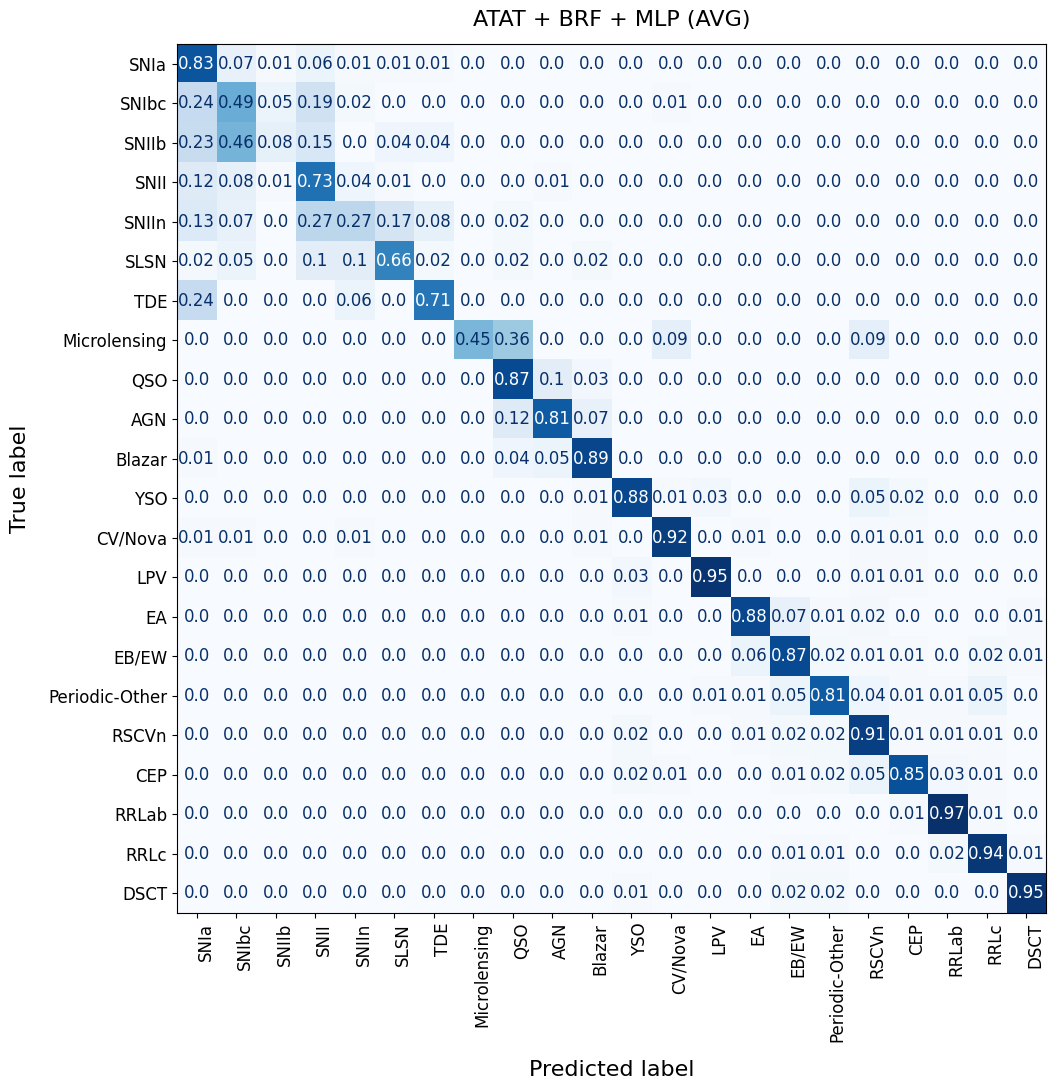

In [41]:
cm_matrix(y_test, y_pred_mean_label, 'AVG')

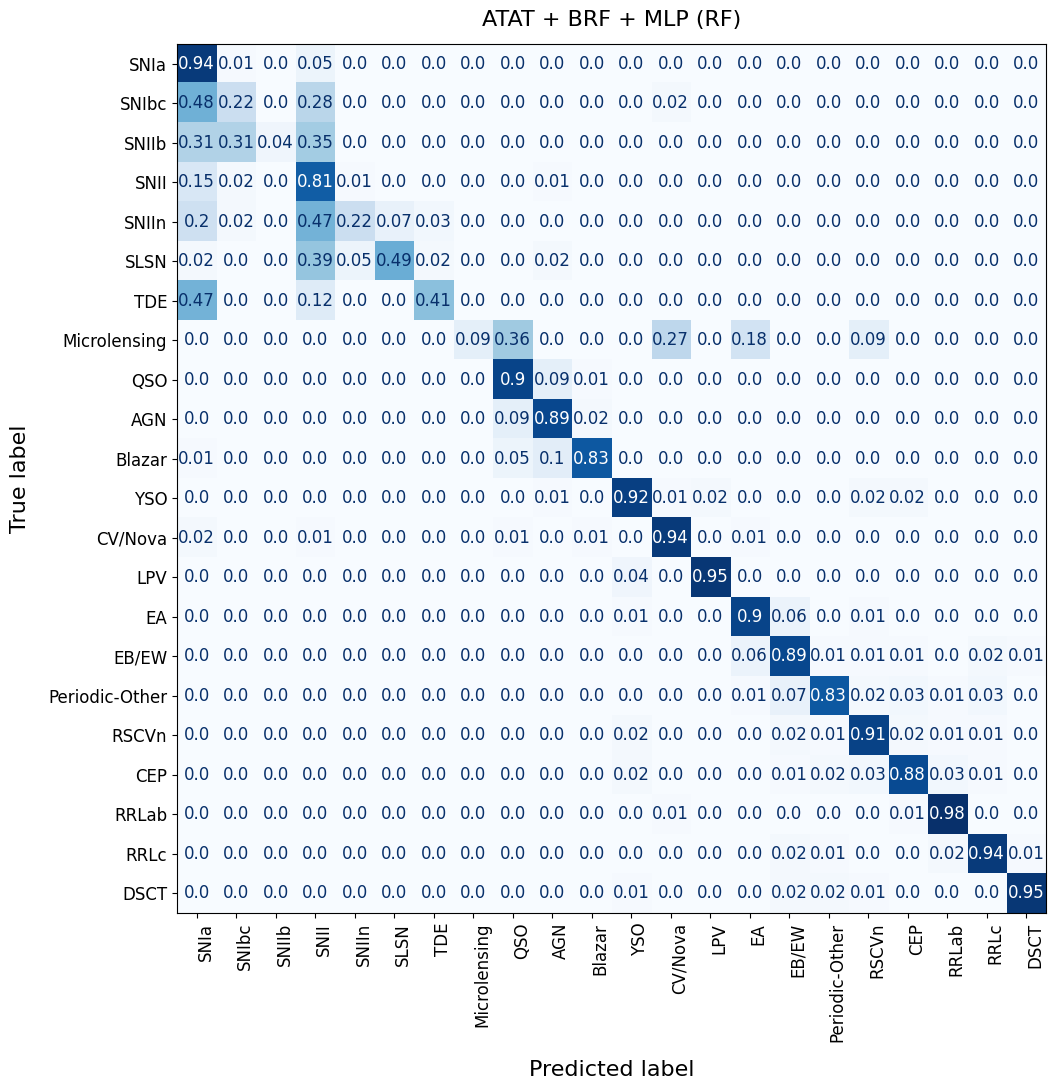

In [46]:
cm_matrix(y_test, y_pred_rf_label, 'RF')

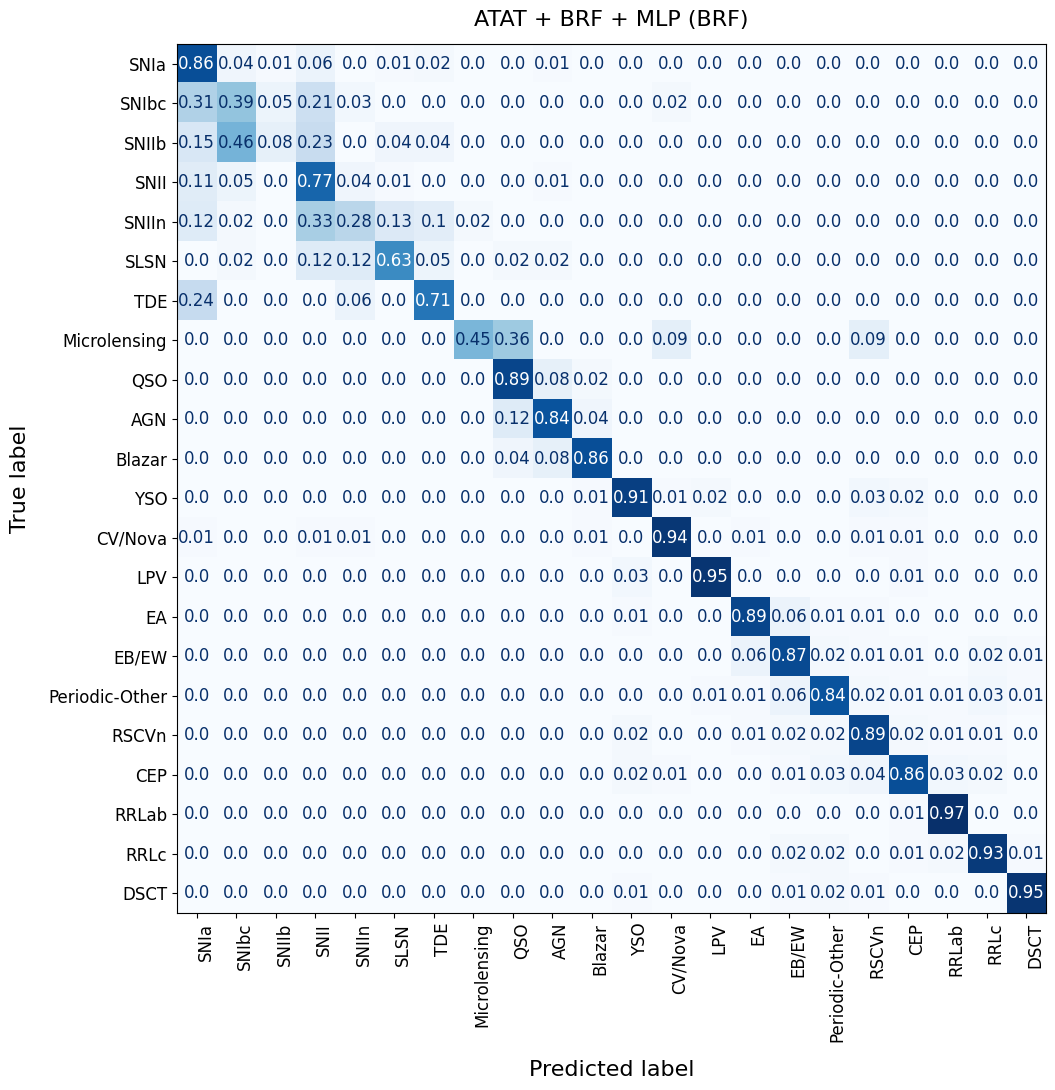

In [44]:
cm_matrix(y_test, y_pred_brf_label, 'BRF')

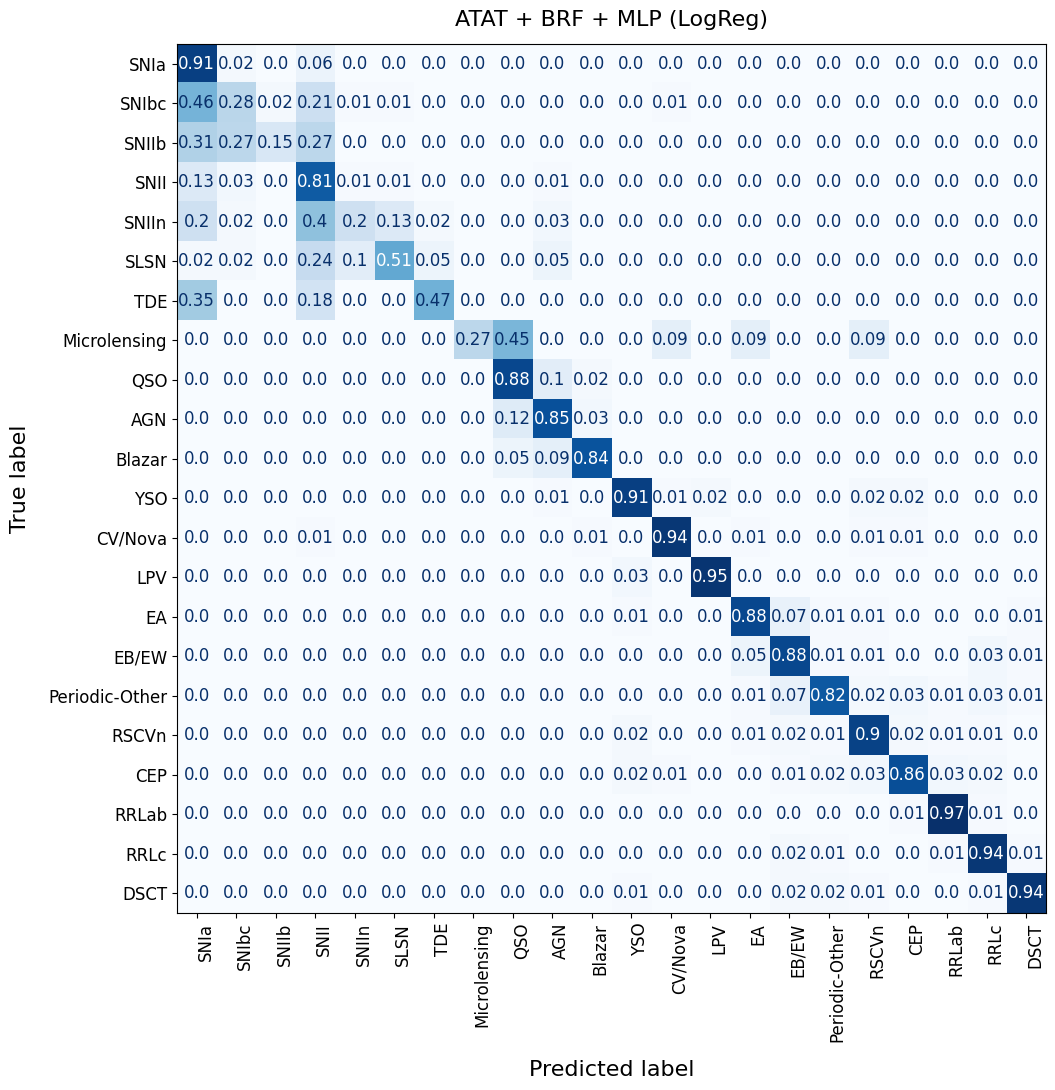

In [47]:
cm_matrix(y_test, y_pred_lr_label, 'LogReg')

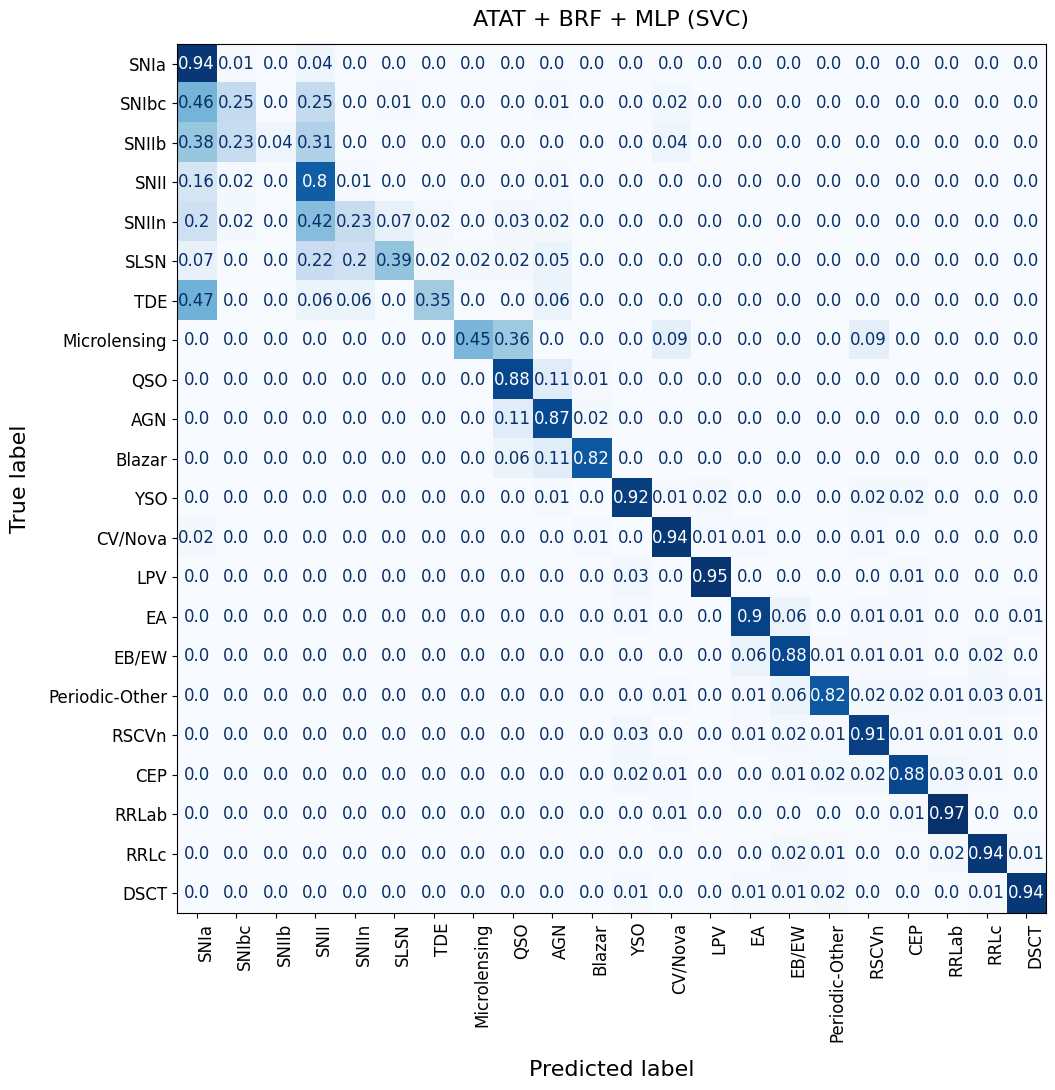

In [48]:
cm_matrix(y_test, y_pred_svc_label, 'SVC')

In [ ]:
meta_model_val = LinearRegression()
meta_model.fit(X_val_meta, y_val)

In [ ]:
dict_mlp_predictions = dict({
    'list_y_pred': dict(),
    'list_y_pred_prob': dict(),
    })
dict_brf_predictions = dict({
    'list_y_pred': dict(),
    'list_y_pred_prob': dict(),
    })

for time_to_eval in list_times_to_eval:
    mlp_pred_x_time = mlp_predictions[mlp_predictions['shorten'] == time_to_eval]
    mlp_pred_x_time = mlp_pred_x_time.reindex(ids_unique)[sort_classes]

    brf_pred_x_time = brf_predictions[brf_predictions['shorten'] == time_to_eval]
    brf_pred_x_time = brf_pred_x_time.reindex(ids_unique)[sort_classes]

    if time_to_eval == 'None':
        dict_mlp_predictions['list_y_pred_prob']['test_2048'] = mlp_pred_x_time.values
        dict_mlp_predictions['list_y_pred']['test_2048'] = np.argmax(mlp_pred_x_time.values, axis=1)
        
        dict_brf_predictions['list_y_pred_prob']['test_2048'] = brf_pred_x_time.values
        dict_brf_predictions['list_y_pred']['test_2048'] = np.argmax(brf_pred_x_time.values, axis=1)

    else:
        dict_mlp_predictions['list_y_pred_prob']['test_{}'.format(time_to_eval)] = mlp_pred_x_time.values
        dict_mlp_predictions['list_y_pred']['test_{}'.format(time_to_eval)] = np.argmax(mlp_pred_x_time.values, axis=1)
        
        dict_brf_predictions['list_y_pred_prob']['test_{}'.format(time_to_eval)] = brf_pred_x_time.values
        dict_brf_predictions['list_y_pred']['test_{}'.format(time_to_eval)] = np.argmax(brf_pred_x_time.values, axis=1)


In [ ]:
dict_all_predictions = {
    'MLP': dict_mlp_predictions,
    'BRF': dict_brf_predictions,
    'ATAT': predictions,
    'y_test': dict_avg_pred_models['y_test'],
}